# Notebook for Run Training

## Import module

In [1]:
import pickle
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run
from neuralhydrology.nh_run_scheduler import schedule_runs
from neuralhydrology.evaluation.plots import percentile_plot, regression_plot, uncertainty_plot

## Training Model

1. Base Model = LSTM without dropout rate
2. MCD Model = LSTM with Regression head, Monte Carlo Dropout, and dropout rate
3. UMAL Model = LSTM with UMAL head and dropout rate

### Base Model

In [ ]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    start_run(config_file=Path("base_model_cudalstm.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("base_model_cudalstm.yml"), gpu=-1)

### MCD Model

In [ ]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    start_run(config_file=Path("mcd_model_cudalstm.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("mcd_model_cudalstm.yml"), gpu=-1)

### UMAL Model

In [ ]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    start_run(config_file=Path("umal_model_cudalstm.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("umal_model_cudalstm.yml"), gpu=-1)

## Evaluate run on test set
The run directory that needs to be specified for evaluation is printed in the output log above. Since the folder name is created dynamically (including the date and time of the start of the run) you will need to change the `run_dir` argument according to your local directory name. By default, it will use the same device as during the training process.

In [ ]:
# Probabilistic model
run_dir = Path("run_cudalstm_mcd_model")
eval_run(run_dir=run_dir, period="test")

### Load and inspect model predictions
Next, we load the results file and compare the model predictions with observations. The results file is always a pickled dictionary with one key per basin (even for a single basin). The next-lower dictionary level is the temporal resolution of the predictions. In this case, we trained a model only on daily data ('1D'). Within the temporal resolution, the next-lower dictionary level are `xr`(an xarray Dataset that contains observations and predictions), as well as one key for each metric that was specified in the config file.

In [ ]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

The data variables in the xarray Dataset are named according to the name of the target variables, with suffix `_obs` for the observations and suffix `_sim` for the simulations.

In [ ]:
# Clipping the results time step until 31-12-2008 and add mean and median var per basin
for key in results.keys():
    # For each dataset in the dictionary
    dataset = results[key]['1D']['xr']  # Adjust this path based on your dict structure
    dataset['QObs(mm/d)_sim_mean'] = dataset['QObs(mm/d)_sim'].mean(dim='samples')
    dataset['QObs(mm/d)_sim_median'] = dataset['QObs(mm/d)_sim'].median(dim='samples')
    # Select data up to and including 31st December 2008
    results[key]['1D']['xr'] = dataset.sel(date=slice(None, '2008-12-31'))

In [ ]:
# Calculate all metrics for each basin using mean and median results of probabilistic forecasting
for key in results.keys():
    dataset = results[key]['1D']['xr']  # Adjust this path based on your dict structure
    
    # Extract observed data
    qobs = dataset['QObs(mm/d)_obs'].isel(time_step=-1)
    # Extract mean and median simulated data
    qsim_mean = dataset['QObs(mm/d)_sim_mean'].isel(time_step=-1)
    qsim_median = dataset['QObs(mm/d)_sim_median'].isel(time_step=-1)

    # Calculate metrics for mean simulated data
    mean_metrics = metrics.calculate_all_metrics(qobs, qsim_mean)
    # Store mean metrics in the dictionary
    results[key]['1D']['mean_metrics'] = mean_metrics

    # Calculate metrics for median simulated data
    median_metrics = metrics.calculate_all_metrics(qobs, qsim_median)
    # Store median metrics in the dictionary
    results[key]['1D']['median_metrics'] = median_metrics

In [ ]:
from collections import defaultdict

# Initialize dictionaries to store the sum of metrics
sum_mean_metrics = defaultdict(float)
sum_median_metrics = defaultdict(float)
num_basins = len(results)

# Iterate over each key (basin) in results
for key in results.keys():
    # Retrieve mean_metrics and median_metrics directly from the dictionary
    if 'mean_metrics' in results[key]['1D'] and 'median_metrics' in results[key]['1D']:
        mean_metrics = results[key]['1D']['mean_metrics']
        median_metrics = results[key]['1D']['median_metrics']

        # Sum the metrics for each basin
        for metric, value in mean_metrics.items():
            sum_mean_metrics[metric] += value
        for metric, value in median_metrics.items():
            sum_median_metrics[metric] += value

# Calculate the average for mean_metrics and median_metrics
average_mean_metrics = {metric: sum_val / num_basins for metric, sum_val in sum_mean_metrics.items()}
average_median_metrics = {metric: sum_val / num_basins for metric, sum_val in sum_median_metrics.items()}

In [ ]:
# Print the average metrics
print("Average of Mean-Probf vs One-Point Metrics Across All Basins:")
for metric, avg_val in average_mean_metrics.items():
    print(f"{metric}: {avg_val:.3f}")

print("\nAverage of Median-Probf vs One-Point Metrics Across All Basins:")
for metric, avg_val in average_median_metrics.items():
    print(f"{metric}: {avg_val:.3f}")

Let's plot the model predictions vs. the observations

In [ ]:
# Extract observations and simulations
qobs = results['14187000']['1D']['xr']['QObs(mm/d)_obs']
qsim = results['14187000']['1D']['xr']['QObs(mm/d)_sim']

# Plot observations
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(qobs['date'], qobs, label='Observations')

# Plot all simulation samples
for i in range(qsim.shape[2]):
    ax.plot(qsim['date'], qsim.isel(samples=i), color='orange', alpha=0.2, label='_nolegend_')  # Plot each sample with low alpha for transparency

ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['14187000']['1D']['NSE']:.3f}")
ax.legend()
plt.show()


## Evaluate model with different basin (e.g. HUC 18)

In [2]:
# Probabilistic model
run_dir = Path("run_cudalstm_mcd_model")
eval_run(run_dir=run_dir, period="test")

# Evaluation: 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:24<00:00,  1.64it/s]


### Load and inspect model predictions
Next, we load the results file and compare the model predictions with observations. The results file is always a pickled dictionary with one key per basin (even for a single basin). The next-lower dictionary level is the temporal resolution of the predictions. In this case, we trained a model only on daily data ('1D'). Within the temporal resolution, the next-lower dictionary level are `xr`(an xarray Dataset that contains observations and predictions), as well as one key for each metric that was specified in the config file.

In [3]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['10258000', '10258500', '10259000', '10259200', '10263500', '11098000', '11124500', '11141280', '11143000', '11148900', '11151300', '11162500', '11176400', '11180500', '11180960', '11224500', '11230500', '11237500', '11253310', '11264500', '11266500', '11274500', '11274630', '11284400', '11299600', '11381500', '11383500', '11451100', '11468500', '11473900', '11475560', '11476600', '11478500', '11480390', '11481200', '11482500', '11522500', '11523200', '11528700', '11532500'])

The data variables in the xarray Dataset are named according to the name of the target variables, with suffix `_obs` for the observations and suffix `_sim` for the simulations.

In [4]:
# Clipping the results time step until 31-12-2008 and add mean and median var per basin
for key in results.keys():
    # For each dataset in the dictionary
    dataset = results[key]['1D']['xr']  # Adjust this path based on your dict structure
    dataset['QObs(mm/d)_sim_mean'] = dataset['QObs(mm/d)_sim'].mean(dim='samples')
    dataset['QObs(mm/d)_sim_median'] = dataset['QObs(mm/d)_sim'].median(dim='samples')
    # Select data up to and including 31st December 2008
    results[key]['1D']['xr'] = dataset.sel(date=slice(None, '2008-12-31'))

In [5]:
# Calculate all metrics for each basin using mean and median results of probabilistic forecasting
for key in results.keys():
    dataset = results[key]['1D']['xr']  # Adjust this path based on your dict structure
    
    # Extract observed data
    qobs = dataset['QObs(mm/d)_obs'].isel(time_step=-1)
    # Extract mean and median simulated data
    qsim_mean = dataset['QObs(mm/d)_sim_mean'].isel(time_step=-1)
    qsim_median = dataset['QObs(mm/d)_sim_median'].isel(time_step=-1)

    # Calculate metrics for mean simulated data
    mean_metrics = metrics.calculate_all_metrics(qobs, qsim_mean)
    # Store mean metrics in the dictionary
    results[key]['1D']['mean_metrics'] = mean_metrics

    # Calculate metrics for median simulated data
    median_metrics = metrics.calculate_all_metrics(qobs, qsim_median)
    # Store median metrics in the dictionary
    results[key]['1D']['median_metrics'] = median_metrics

In [6]:
from collections import defaultdict

# Initialize dictionaries to store the sum of metrics
sum_mean_metrics = defaultdict(float)
sum_median_metrics = defaultdict(float)
num_basins = len(results)

# Iterate over each key (basin) in results
for key in results.keys():
    # Retrieve mean_metrics and median_metrics directly from the dictionary
    if 'mean_metrics' in results[key]['1D'] and 'median_metrics' in results[key]['1D']:
        mean_metrics = results[key]['1D']['mean_metrics']
        median_metrics = results[key]['1D']['median_metrics']

        # Sum the metrics for each basin
        for metric, value in mean_metrics.items():
            sum_mean_metrics[metric] += value
        for metric, value in median_metrics.items():
            sum_median_metrics[metric] += value

# Calculate the average for mean_metrics and median_metrics
average_mean_metrics = {metric: sum_val / num_basins for metric, sum_val in sum_mean_metrics.items()}
average_median_metrics = {metric: sum_val / num_basins for metric, sum_val in sum_median_metrics.items()}

In [7]:
# Print the average metrics
print("Average of Mean-Probf vs One-Point Metrics Across All Basins:")
for metric, avg_val in average_mean_metrics.items():
    print(f"{metric}: {avg_val:.3f}")

print("\nAverage of Median-Probf vs One-Point Metrics Across All Basins:")
for metric, avg_val in average_median_metrics.items():
    print(f"{metric}: {avg_val:.3f}")

Average of Mean-Probf vs One-Point Metrics Across All Basins:
NSE: -319.621
MSE: 75.414
RMSE: 6.594
KGE: -28.845
Alpha-NSE: 5.780
Beta-KGE: 29.649
Beta-NSE: 5.685
Pearson-r: 0.481
FHV: 347.703
FMS: -25.364
FLV: -68665386265.196
Peak-Timing: 0.691
Peak-MAPE: 122.878

Average of Median-Probf vs One-Point Metrics Across All Basins:
NSE: -312.418
MSE: 74.709
RMSE: 6.628
KGE: -27.078
Alpha-NSE: 6.056
Beta-KGE: 27.646
Beta-NSE: 5.278
Pearson-r: 0.459
FHV: 358.923
FMS: 86.866
FLV: -29606915824.622
Peak-Timing: 1.069
Peak-MAPE: 121.681


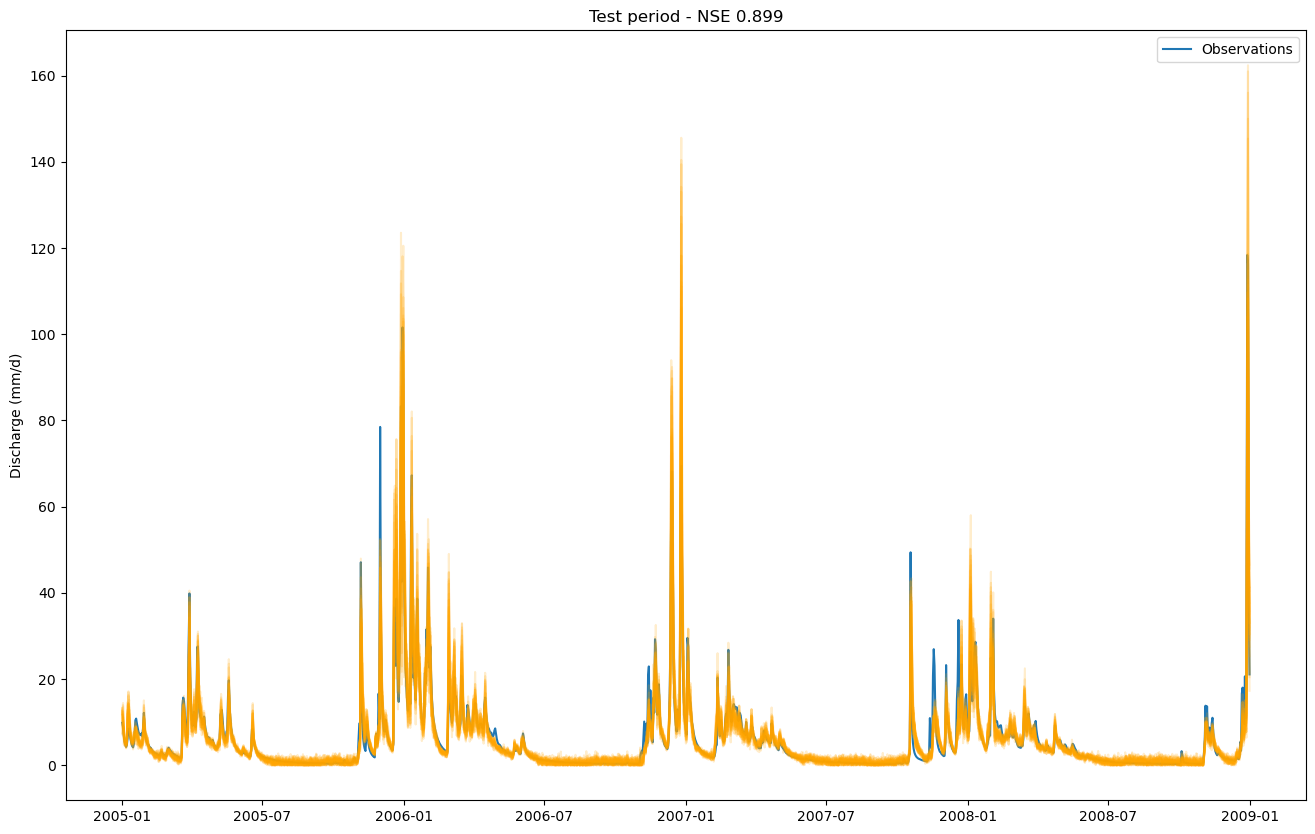

In [8]:
# Extract observations and simulations
qobs = results['11532500']['1D']['xr']['QObs(mm/d)_obs']
qsim = results['11532500']['1D']['xr']['QObs(mm/d)_sim']

# Plot observations
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(qobs['date'], qobs, label='Observations')

# Plot all simulation samples
for i in range(qsim.shape[2]):
    ax.plot(qsim['date'], qsim.isel(samples=i), color='orange', alpha=0.2, label='_nolegend_')  # Plot each sample with low alpha for transparency

ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['11532500']['1D']['NSE']:.3f}")
ax.legend()
plt.show()


(<Figure size 640x480 with 1 Axes>, <Axes: >)

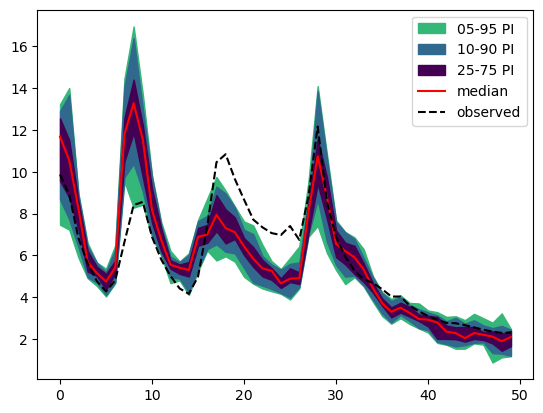

In [9]:
percentile_plot(qobs.values[0:50], qsim[0:50])

In [10]:
# Preprocess result before evaluation
qsim_pi = qsim.values.swapaxes(0, 2).squeeze()
qobs_pi = qobs.values.squeeze()

In [20]:
# Evaluation metrics for probabilistic forecasting
metrics.calculate_all_metrics_prob(qobs_pi,qsim_pi,95)

{'PINAW': 0.3964443755921793, 'PICP': 82.95687885010267}

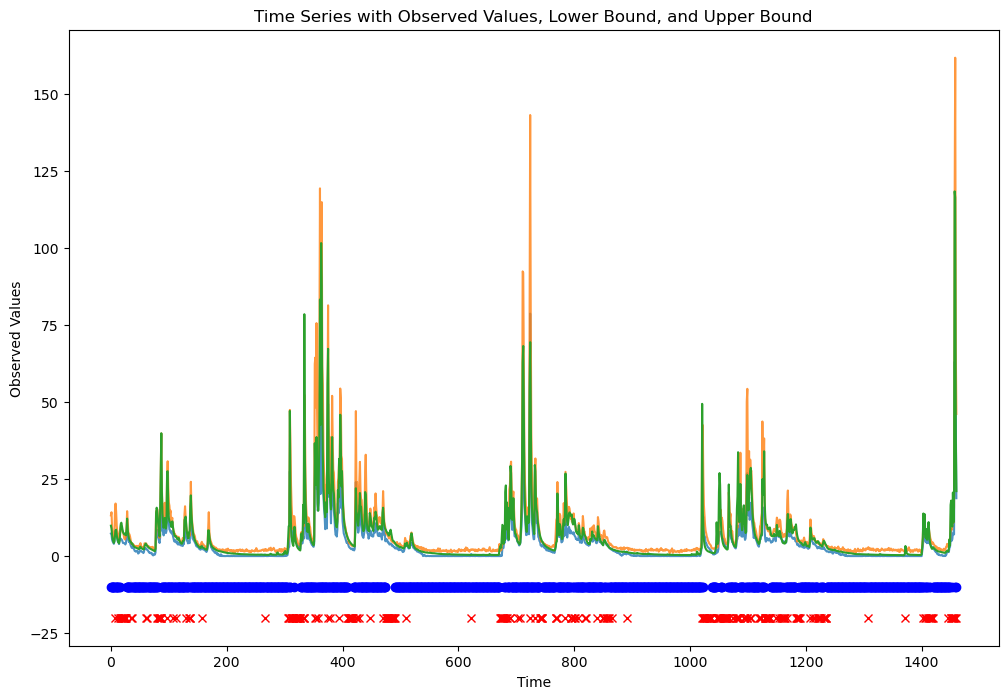

In [22]:
plt.subplots(figsize=(12,8))
plt.plot(lb, alpha=0.8)
plt.plot(ub, alpha=0.8)
plt.plot(qobs.values)

time = np.arange(0, len(qobs.values), 1)

# Create a plot
for i in range(len(qobs.values)):
    if (qobs.values[i] >= np.array(lb[i])) and (qobs.values[i] <= np.array(ub[i])):
        plt.plot(time[i], -10, marker='o',color='blue')
    else:
        plt.plot(time[i], -20, marker='x',color='red')

plt.xlabel('Time')
plt.ylabel('Observed Values')
plt.title('Time Series with Observed Values, Lower Bound, and Upper Bound')
plt.show()
